In [1]:
# Install required libraries
!pip install pandas numpy scikit-learn joblib matplotlib seaborn

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
# Load dataset (Update path if needed)
file_path = "air_quality_dataset_with_methane_1.csv"
df = pd.read_csv(file_path)

In [4]:
# Convert timestamp to datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"], dayfirst=True)

# Encode Location (convert categorical to numeric)
le = LabelEncoder()
df["Location"] = le.fit_transform(df["Location"])

# Save label encoder
joblib.dump(le, "location_encoder2.pkl")

['location_encoder2.pkl']

In [5]:
# Define AQI category mapping function
def map_aqi_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi <= 200:
        return "Unhealthy"
    elif aqi <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

# Apply mapping to Overall_AQI
df["AQI_Category"] = df["Overall_AQI"].apply(map_aqi_category)

In [6]:
# Define features and targets for individual AQI predictions
# For individual AQI models
individual_features = {
    "NH3_AQI": ["NH3_ppm"],
    "CO_AQI": ["CO_ppm"],
    "O3_AQI": ["O3_ppm"],
    "CH4_AQI": ["CH4_ppm"]
}

In [7]:
# For Overall AQI model (excluding CH4)
overall_features = ["NH3_ppm", "CO_ppm", "CH4_ppm"]
overall_target = "Overall_AQI"

In [8]:
# Create dictionaries to store models, scalers and metrics
individual_models = {}
individual_scalers = {}
individual_metrics = {}

In [9]:
# Train individual AQI prediction models using Gradient Boosting Regressor
for target, features in individual_features.items():
    print(f"\nTraining model for {target} using Gradient Boosting...")
    
    # Define X and y
    X = df[features]
    y = df[target]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Save scaler
    individual_scalers[target] = scaler
    joblib.dump(scaler, f"{target}_scaler2.pkl")
    
    # Train model
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Save model
    individual_models[target] = model
    joblib.dump(model, f"{target}_model2.pkl")
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    individual_metrics[target] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }
    
    # Print metrics
    print(f"{target} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
    plt.xlabel(f"Actual {target}")
    plt.ylabel(f"Predicted {target}")
    plt.title(f"Actual vs Predicted {target}")
    plt.savefig(f"{target}_prediction_plot2.png")
    plt.close()


Training model for NH3_AQI using Gradient Boosting...
NH3_AQI - MAE: 26.2588, RMSE: 38.5771, R²: 0.9153

Training model for CO_AQI using Gradient Boosting...
CO_AQI - MAE: 19.4141, RMSE: 30.4255, R²: 0.9501

Training model for O3_AQI using Gradient Boosting...
O3_AQI - MAE: 18.1345, RMSE: 28.8079, R²: 0.9520

Training model for CH4_AQI using Gradient Boosting...
CH4_AQI - MAE: 19.4223, RMSE: 29.9628, R²: 0.9487



Training model for Overall_AQI GBR...
Overall_AQI - MAE: 18.9277, RMSE: 29.9935, R²: 0.9457


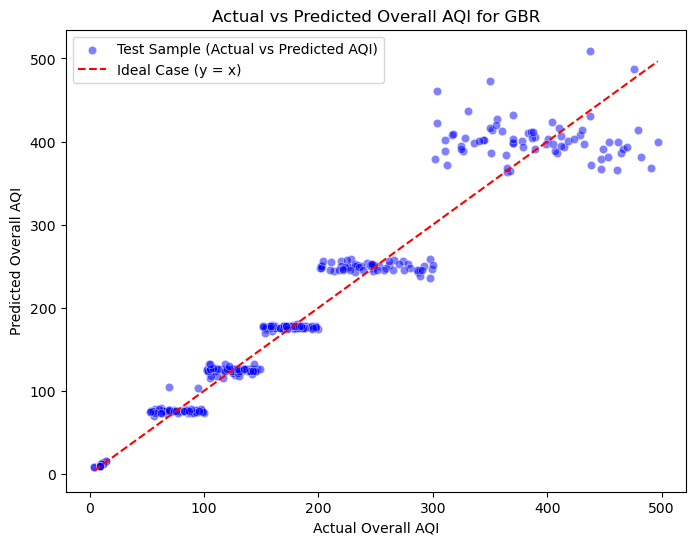

In [20]:
print("\nTraining model for Overall_AQI GBR...")

# Define X (features) and y (target variable) for Overall AQI
X_overall = df[overall_features]
y_overall = df[overall_target]

# Split data
X_train_overall, X_test_overall, y_train_overall, y_test_overall = train_test_split(
    X_overall, y_overall, test_size=0.2, random_state=42
)

# Scale features
overall_scaler = StandardScaler()
X_train_overall_scaled = overall_scaler.fit_transform(X_train_overall)
X_test_overall_scaled = overall_scaler.transform(X_test_overall)

# Save scaler
joblib.dump(overall_scaler, "overall_aqi_scaler2.pkl")

# Train model
overall_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
overall_model.fit(X_train_overall_scaled, y_train_overall)

# Save model
joblib.dump(overall_model, "overall_aqi_model2.pkl")

# Predictions
y_overall_pred = overall_model.predict(X_test_overall_scaled)

# Metrics
overall_mae = mean_absolute_error(y_test_overall, y_overall_pred)
overall_mse = mean_squared_error(y_test_overall, y_overall_pred)
overall_rmse = np.sqrt(overall_mse)
overall_r2 = r2_score(y_test_overall, y_overall_pred)

# Print metrics
print(f"Overall_AQI - MAE: {overall_mae:.4f}, RMSE: {overall_rmse:.4f}, R²: {overall_r2:.4f}")

# Plot Overall AQI
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_overall, y=y_overall_pred, alpha=0.5, color='blue', label="Test Sample (Actual vs Predicted AQI)")
plt.plot([min(y_test_overall), max(y_test_overall)], [min(y_test_overall), max(y_test_overall)], 
         color="red", linestyle="--", label="Ideal Case (y = x)")
plt.xlabel("Actual Overall AQI")
plt.ylabel("Predicted Overall AQI")
plt.title("Actual vs Predicted Overall AQI for GBR")
plt.savefig("overall_aqi_prediction_plot2.png")
plt.legend()
plt.show()

In [11]:
# Hyperparameter Tuning for Overall AQI model
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42), 
    param_grid, 
    cv=3, 
    scoring='neg_mean_absolute_error'
)
grid_search.fit(X_train_overall_scaled, y_train_overall)

# Best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters for Overall AQI model:", best_params)

Best Hyperparameters for Overall AQI model: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


In [12]:
# Train model with best parameters
best_overall_model = grid_search.best_estimator_
best_overall_model.fit(X_train_overall_scaled, y_train_overall)

# Save best model
joblib.dump(best_overall_model, "best_overall_aqi_model2.pkl")

['best_overall_aqi_model2.pkl']

In [13]:
y_best_overall_pred = best_overall_model.predict(X_test_overall_scaled)

In [14]:
def predict_all_aqi(nh3_ppm, co_ppm, o3_ppm, ch4_ppm, location=None):
    """
    Predict all individual AQI values and Overall AQI for new input data
    
    Parameters:
    -----------
    nh3_ppm : float
        NH3 concentration in ppm
    co_ppm : float
        CO concentration in ppm
    o3_ppm : float
        O3 concentration in ppm
    ch4_ppm : float
        CH4 concentration in ppm
    location : str, optional
        Location (will be encoded if provided)
    
    Returns:
    --------
    dict
        Dictionary with all predicted AQI values and categories
    """
    # Create input data for individual AQI predictions
    input_data = {
        "NH3_AQI": np.array([[nh3_ppm]]),
        "CO_AQI": np.array([[co_ppm]]),
        "O3_AQI": np.array([[o3_ppm]]),
        "CH4_AQI": np.array([[ch4_ppm]])
    }
    
    # Create input data for Overall AQI prediction
    overall_input = np.array([[nh3_ppm, co_ppm, ch4_ppm]])
    
    # Scale inputs
    scaled_inputs = {}
    for target, data in input_data.items():
        scaled_inputs[target] = individual_scalers[target].transform(data)
    
    overall_input_scaled = overall_scaler.transform(overall_input)
    
    # Make predictions
    predictions = {}
    for target, scaled_data in scaled_inputs.items():
        predictions[target] = float(individual_models[target].predict(scaled_data)[0])
    
    # Predict Overall AQI
    predictions["Overall_AQI"] = float(best_overall_model.predict(overall_input_scaled)[0])
    
    # Add AQI categories (create a copy of keys to avoid modifying during iteration)
    aqi_keys = list(predictions.keys())
    for aqi_key in aqi_keys:
        category_key = aqi_key.replace("AQI", "Category")
        predictions[category_key] = map_aqi_category(predictions[aqi_key])
    
    return predictions

In [15]:
# Test the prediction function with sample data
sample_data = df.iloc[0]
sample_prediction = predict_all_aqi(
    sample_data["NH3_ppm"],
    sample_data["CO_ppm"],
    sample_data["O3_ppm"],
    sample_data["CH4_ppm"]
)

print("\nSample Prediction:")
for key, value in sample_prediction.items():
    print(f"{key}: {value}")

# Save the prediction function
joblib.dump(predict_all_aqi, "predict_all_aqi_function2.pkl")


Sample Prediction:
NH3_AQI: 5.922605053529318
CO_AQI: 1.8830516084822762
O3_AQI: 10.109517918138158
CH4_AQI: 7.804754490401499
Overall_AQI: 10.202097022462018
NH3_Category: Good
CO_Category: Good
O3_Category: Good
CH4_Category: Good
Overall_Category: Good


c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


['predict_all_aqi_function2.pkl']

In [16]:
# Create a comprehensive results DataFrame for evaluation
# Get predictions for test data
test_predictions = {
    "Actual_NH3_AQI": [],
    "Predicted_NH3_AQI": [],
    "Actual_CO_AQI": [],
    "Predicted_CO_AQI": [],
    "Actual_O3_AQI": [],
    "Predicted_O3_AQI": [],
    "Actual_CH4_AQI": [],
    "Predicted_CH4_AQI": [],
    "Actual_Overall_AQI": [],
    "Predicted_Overall_AQI": [],
    "Actual_AQI_Category": [],
    "Predicted_AQI_Category": []
}

# Get indices of test data
test_indices = y_test_overall.index

In [17]:
# For each test instance
for idx in test_indices:
    row = df.loc[idx]
    
    # Make prediction for this instance
    pred = predict_all_aqi(
        row["NH3_ppm"],
        row["CO_ppm"],
        row["O3_ppm"],
        row["CH4_ppm"]
    )
    
    # Store actual and predicted values
    test_predictions["Actual_NH3_AQI"].append(row["NH3_AQI"])
    test_predictions["Predicted_NH3_AQI"].append(pred["NH3_AQI"])
    
    test_predictions["Actual_CO_AQI"].append(row["CO_AQI"])
    test_predictions["Predicted_CO_AQI"].append(pred["CO_AQI"])
    
    test_predictions["Actual_O3_AQI"].append(row["O3_AQI"])
    test_predictions["Predicted_O3_AQI"].append(pred["O3_AQI"])
    
    test_predictions["Actual_CH4_AQI"].append(row["CH4_AQI"])
    test_predictions["Predicted_CH4_AQI"].append(pred["CH4_AQI"])
    
    test_predictions["Actual_Overall_AQI"].append(row["Overall_AQI"])
    test_predictions["Predicted_Overall_AQI"].append(pred["Overall_AQI"])
    
    test_predictions["Actual_AQI_Category"].append(row["AQI_Category"])
    test_predictions["Predicted_AQI_Category"].append(pred["Overall_Category"])

c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid f

In [18]:
# Convert to DataFrame
results_df = pd.DataFrame(test_predictions)

# Display first few rows
print("\nSample Results:")
print(results_df.head())

# Save results
results_df.to_csv("aqi_prediction_results2.csv", index=False)

print("\nAll models trained and saved successfully!")


Sample Results:
   Actual_NH3_AQI  Predicted_NH3_AQI  Actual_CO_AQI  Predicted_CO_AQI  \
0      113.120061         121.224170     115.212490        125.480243   
1      446.787051         412.570499     432.550450        416.083707   
2      429.172787         404.101855     488.320539        413.527729   
3      144.114263         121.224170     140.633760        127.304118   
4        0.350000           7.554802       1.022727          1.883052   

   Actual_O3_AQI  Predicted_O3_AQI  Actual_CH4_AQI  Predicted_CH4_AQI  \
0     119.718548        126.293827      140.346446         126.539449   
1     483.020661        396.012797      399.869608         421.464749   
2     442.701065        400.757847      318.553454         395.029178   
3     121.035483        126.293827      111.360607         126.219294   
4       9.259259         10.109518        7.000000           7.804754   

   Actual_Overall_AQI  Predicted_Overall_AQI             Actual_AQI_Category  \
0          124.508400    

In [19]:
# Define a list of test cases
test_cases = [
    {"NH3_ppm": 0.10, "CO_ppm": 0.15, "O3_ppm": 0.02, "CH4_ppm": 0.09},
    {"NH3_ppm": 0.25, "CO_ppm": 0.30, "O3_ppm": 0.04, "CH4_ppm": 0.12},
    {"NH3_ppm": 0.50, "CO_ppm": 0.60, "O3_ppm": 0.08, "CH4_ppm": 0.20},
    # Add more test cases as needed
]

# Process each test case
print("Batch Testing Results:\n")
for i, case in enumerate(test_cases):
    predictions = predict_all_aqi(
        case["NH3_ppm"], 
        case["CO_ppm"], 
        case["O3_ppm"], 
        case["CH4_ppm"]
    )
    
    print(f"Test Case {i+1}:")
    print(f"Inputs: NH3={case['NH3_ppm']}ppm, CO={case['CO_ppm']}ppm, " 
          f"O3={case['O3_ppm']}ppm, CH4={case['CH4_ppm']}ppm")
    print(f"Overall AQI: {predictions['Overall_AQI']:.2f} ({predictions['Overall_Category']})")
    print(f"NH3 AQI: {predictions['NH3_AQI']:.2f} ({predictions['NH3_Category']})")
    print(f"CO AQI: {predictions['CO_AQI']:.2f} ({predictions['CO_Category']})")
    print(f"O3 AQI: {predictions['O3_AQI']:.2f} ({predictions['O3_Category']})")
    print(f"CH4 AQI: {predictions['CH4_AQI']:.2f} ({predictions['CH4_Category']})")
    print("-" * 50)

Batch Testing Results:

Test Case 1:
Inputs: NH3=0.1ppm, CO=0.15ppm, O3=0.02ppm, CH4=0.09ppm
Overall AQI: 10.47 (Good)
NH3 AQI: 55.34 (Moderate)
CO AQI: 2.00 (Good)
O3 AQI: 10.11 (Good)
CH4 AQI: 9.45 (Good)
--------------------------------------------------
Test Case 2:
Inputs: NH3=0.25ppm, CO=0.3ppm, O3=0.04ppm, CH4=0.12ppm
Overall AQI: 13.48 (Good)
NH3 AQI: 150.08 (Unhealthy)
CO AQI: 2.50 (Good)
O3 AQI: 53.44 (Moderate)
CH4 AQI: 12.40 (Good)
--------------------------------------------------
Test Case 3:
Inputs: NH3=0.5ppm, CO=0.6ppm, O3=0.08ppm, CH4=0.2ppm
Overall AQI: 186.64 (Unhealthy)
NH3 AQI: 247.24 (Very Unhealthy)
CO AQI: 2.50 (Good)
O3 AQI: 126.29 (Unhealthy for Sensitive Groups)
CH4 AQI: 15.08 (Good)
--------------------------------------------------


c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\91812\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid f